# Kaggle Workshop

Kaggle 是一个机器学习爱好者交流平台，可以在上面参加比赛，进行中的比赛一般会有奖金，能把测试数据集结果刷到前几名的都有奖金。大家可以组队刷比赛分数，可以在论坛交流。上面有类似jupyter notebook的叫做kernel，可以跑自己的程序，代码可以分享给别人，有点类似github。Google也有类似产品colab，都可以使用GPU资源。

## 1. Kaggle house price predict
https://www.kaggle.com/c/house-prices-advanced-regression-techniques


![基本信息](house-prices-advanced-regression-techniques1.png)
有79个可解释的变量，位置、房间数、装修情况等等来预测房子价格，但这些都没有谈价来的影响力大。


![评分标准](house-prices-advanced-regression-techniques2.png)
Root Mean Square Error(对数均方根误差): 

给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots,
y_n$，它的定义为

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat
y_i)\right)^2}$$


![数据](house-prices-advanced-regression-techniques3.png)
https://github.com/LaoLiulaoliu/MachineLearning/tree/master/kaggle/house_price



![规则](house-prices-advanced-regression-techniques4.png)
规则：
一人一个帐号，一天最多提交5次，可以组队，但请尊重比赛，不要手动标注结果。


![排行榜](house-prices-advanced-regression-techniques5.png)
排行榜

## 2. Data exploration

下面我们导入需要用到的python library，看一下数据的情况

In [2]:
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

import numpy as np
import pandas as pd
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import missingno
from IPython.display import display, HTML
display(HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
"""))

### 加载数据

看数据统计，有数值型数据，有分类型数据，还有NaN。有的变量的均值大小不一。

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

### 理解数据

#### 查看SalePrice 的分布

Skewness: 1.882876
Kurtosis: 6.536282


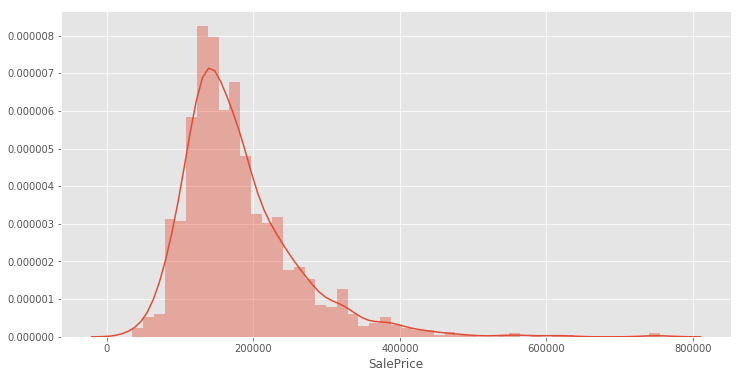

In [6]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(train_data['SalePrice'])

print("Skewness: %f" % train_data['SalePrice'].skew())
print("Kurtosis: %f" % train_data['SalePrice'].kurt())

Skewness: 0.121335
Kurtosis: 0.809532


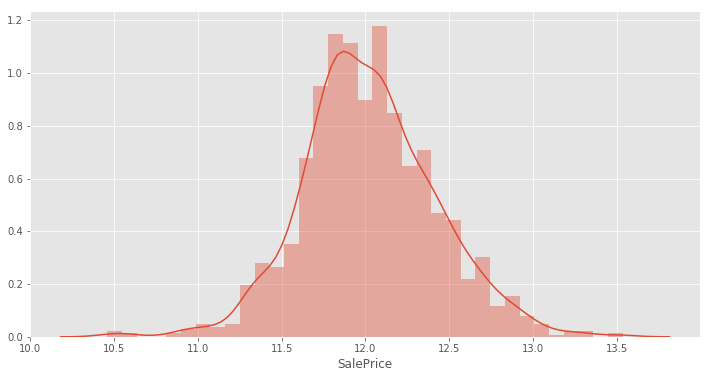

In [7]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(np.log(train_data['SalePrice']))


print("Skewness: %f" % np.log(train_data['SalePrice']).skew()) # -> 0
print("Kurtosis: %f" % np.log(train_data['SalePrice']).kurt()) # -> 1

数据值分布不均衡，对数变换能使得将原本并不均匀的分布变得均匀了，方差更稳定，趋近正态分布。
比如：$$ y = e ^ x $$ 经过log transformation 变成 $$ y = x $$
![](whyLogData.png)
![](whyLogData2.png)

理解为何验证准确率需要用Root Mean Square Error(对数均方根误差)，因为数值比较大的变量的误差，在总误差中占比跟数值小的一样多。

In [8]:
loss = gloss.L2Loss()
def log_rmse(net, features, labels):
    # 将小于1的值设成1，使得取对数时数值更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

#### 根据相关系数矩阵，查看和SalePrice 有关的系数

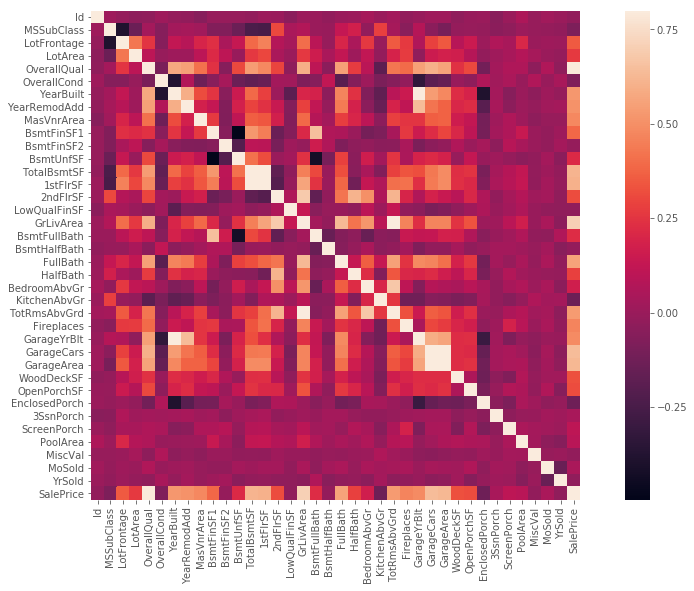

In [9]:
corr_mat = train_data.corr()
f, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

可以看出 OverallQual, YearBuilt, GrLivArea 等变量更SalePrice有关。

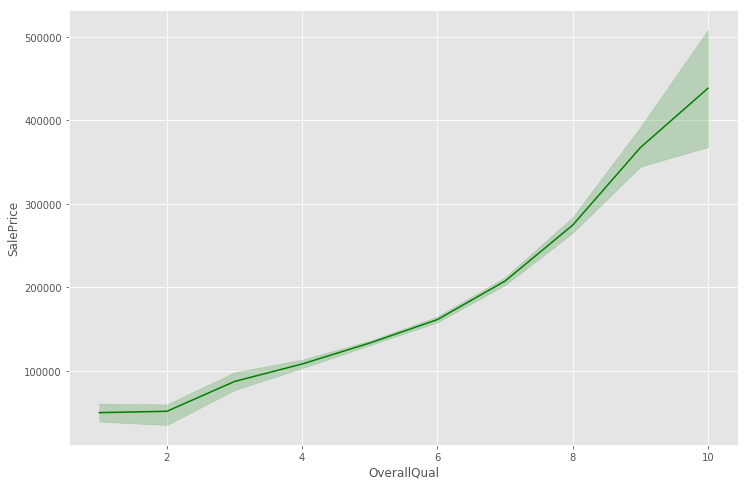

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='OverallQual', y='SalePrice', color='green',data=train_data)

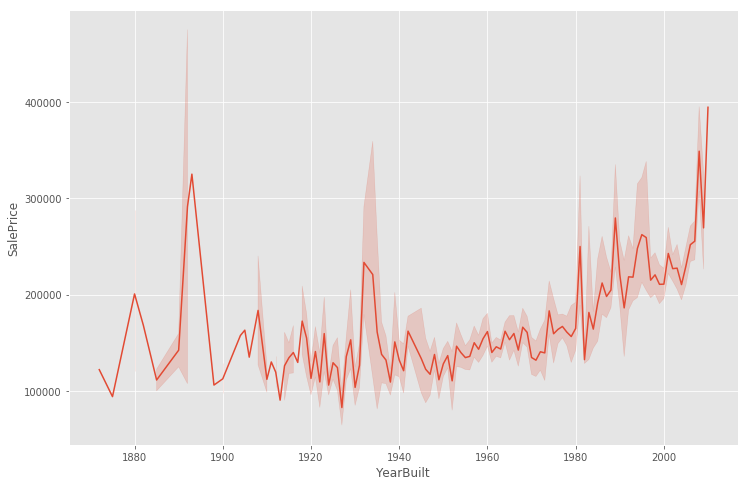

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='YearBuilt', y='SalePrice', data=train_data)

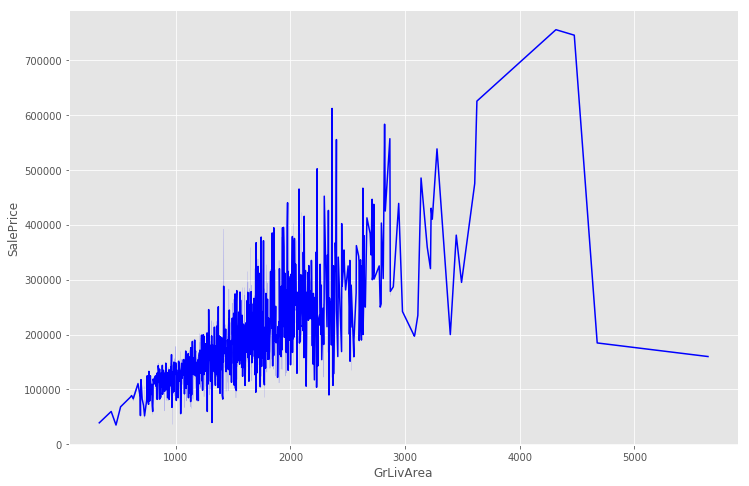

In [12]:
f, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x='GrLivArea', y='SalePrice', color='blue', data=train_data)

我们画图分析，可以认为他们和SalePrice有线性相关性。

### 处理数据

#### 处理missing values

先画出各个变量的missign values，有个直观感受。

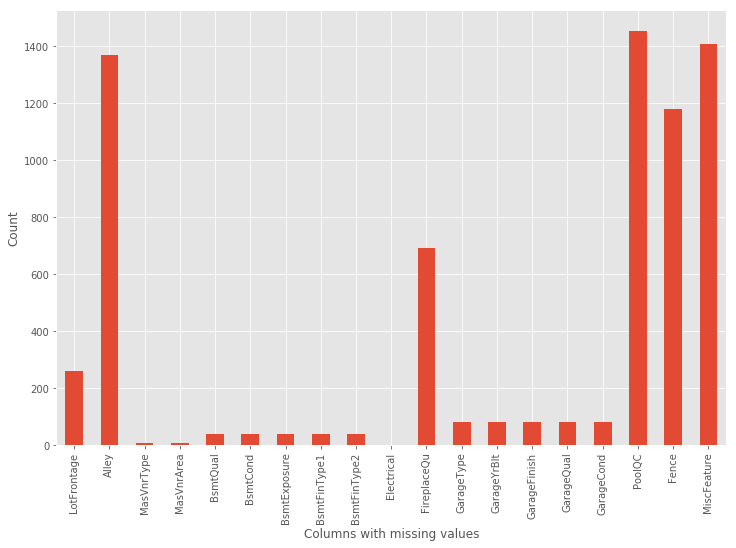

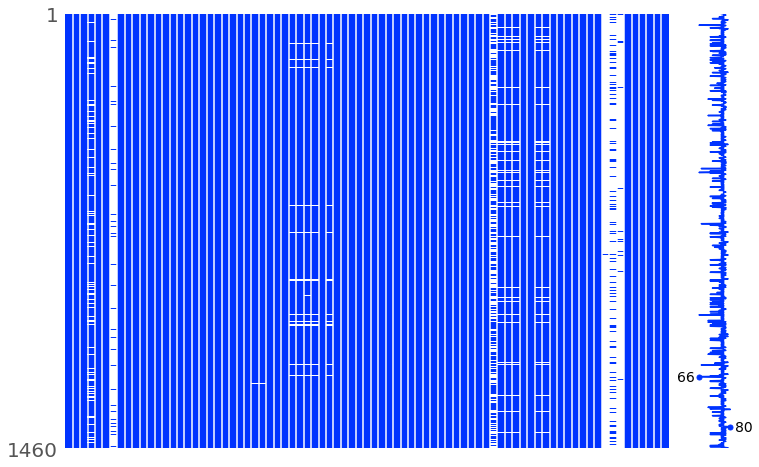

In [12]:
def plot_missing(df):
    nan_sum = df.isnull().sum()
    nan_sum = nan_sum[nan_sum > 0]
    nan_sum.plot.bar(figsize=(12,8))
    plt.xlabel('Columns with missing values')
    plt.ylabel('Count')
    missingno.matrix(df=df, figsize=(12,8), color=(0,0.2,1))
    
plot_missing(train_data)

In [13]:
train = train_data.iloc[:, 1:-1]

missing values 占比太多就drop这个column，剩余的进行填充。

In [15]:
def massive_missing(df, threshod=0.6):
    nan_sum = df.isnull().sum()
    return nan_sum[nan_sum > df.shape[0] * threshod]

missing_series = massive_missing(train, 0.7)
print(missing_series.index)
train = train.drop(missing_series.index, axis=1)

Index([], dtype='object')


给变量做Normalization

In [16]:
numeric_feature = train.dtypes[train.dtypes != 'object'].index
train[numeric_feature] = train[numeric_feature].apply(lambda x: (x - x.mean()) / (x.std()))

对分类型变量插入频率最大的值，对数值型变量插入中数。

In [17]:
def fill_missing_values(df):
    nan_sum = df.isnull().sum()
    nan_sum = nan_sum[nan_sum > 0]
    for column in list(nan_sum.index):
        if df[column].dtype == 'object':
            df[column].fillna(df[column].value_counts().index[0], inplace=True)
        elif df[column].dtype == 'int64' or 'float64':
            df[column].fillna(df[column].median(), inplace=True)
            
fill_missing_values(train)
train.isnull().sum().max()

0

#### one hot representation

In [18]:
train = pd.get_dummies(train)
pd.get_dummies(pd.DataFrame({'a': ['4', '2', '3'], 'b': [1, np.nan, 2]}))

,b,a_2,a_3,a_4
0,1.0,0,0,1
1,NaN,1,0,0
2,2.0,0,1,0


## 3. 构建网络，开始训练

利用gluon可以很方便构建网络，进行训练

In [19]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(10, activation='relu'),
            nn.Dense(1))
    net.initialize()
    return net

def training(net, train_features, train_labels, num_epochs, learning_rate, batch_size):
    train_ls = []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        # print('loss: {}, train rmse: {}'.format(l.mean().asscalar(), train_ls[-1]))
    return train_ls

![neuralNetwork](neuralNetwork_sample.png)

In [20]:
train_features = nd.array(train.values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

num_epochs, learning_rate, batch_size = 300, 0.1, 32
net = get_net()

train_l = training(net, train_features, train_labels, num_epochs, learning_rate, batch_size)
print(train_l)
print('avg train rmse %f' % (train_l[-1], ))

[2.7555418, 1.2743556, 0.52899504, 0.19544037, 0.13386881, 0.12468915, 0.11979244, 0.11955339, 0.120799735, 0.11917452, 0.11843762, 0.115239486, 0.11613143, 0.112957284, 0.11106002, 0.10958181, 0.10671728, 0.107414715, 0.103813455, 0.10267683, 0.10163622, 0.10104036, 0.099976525, 0.09781787, 0.09748271, 0.097221285, 0.09615855, 0.09548287, 0.094801694, 0.094164476, 0.093919404, 0.093134485, 0.09352926, 0.092753336, 0.092343494, 0.09121958, 0.09180049, 0.09075055, 0.090919785, 0.09132997, 0.09017126, 0.09069321, 0.09038684, 0.090288185, 0.09017271, 0.089800894, 0.08975675, 0.09042401, 0.08968471, 0.08893438, 0.0894796, 0.08936239, 0.08956499, 0.08939822, 0.08882659, 0.08913366, 0.08858684, 0.08869145, 0.08881944, 0.08869643, 0.088695854, 0.08853357, 0.088691965, 0.08909379, 0.08866879, 0.0880096, 0.08927812, 0.088306405, 0.08863169, 0.088424414, 0.08889081, 0.088533595, 0.08822781, 0.088746294, 0.08824584, 0.088362806, 0.08893072, 0.08816245, 0.09025489, 0.08803074, 0.088228725, 0.08842

## 4. 预测

预测时，测试数据要做和训练数据一样的预处理。因为预处理需要drop一些变量，而训练数据和测试数据每个变量的missing value 占比可能不同，就会出现训练和测试数据包含的变量不同，导致训练模型不能用于预测，所以需要把训练数据和测试数据放在一起做预处理。包括归一化等操作也需要大家用相同的期望和方差做归一化。

In [27]:
def preprocess(df):
    missing_series = massive_missing(df, 0.7)
    df = df.drop(missing_series.index, axis=1)
    numeric_feature = df.dtypes[df.dtypes != 'object'].index
    df[numeric_feature] = df[numeric_feature].apply(lambda x: (x - x.mean()) / (x.std()))
    fill_missing_values(df)
    df = pd.get_dummies(df)
    return df

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features = preprocess(all_features)

n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))
test_features = nd.array(all_features[n_train:].values)

In [29]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, batch_size):
    net = get_net()
    train_ls = training(net, train_features, train_labels, num_epochs, learning_rate, batch_size)
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, learning_rate, batch_size)

train rmse 0.085622


## 5.数学原理

#### 定义模型假设

为了容易理解，可以把输入数据x 看成m行n列的矩阵（m个样本，n个自变量），y 看成 m维向量，对应x 中m个样本的因变量，组成有m个方程的方程组。下面公式中x的下标表示n个自变量的序号，上标表示m个样本的序号。

假设(Hypothesis)模型是线性模型：
$$ h_{\theta}(x) = \theta_{1}x_{1} + \theta_{2}x_{2} + ... + \theta_{n}x_{n} = \sum_{i=1}^n \theta_{i}x_{i} $$

因为输入的数据x 是已知的，

模型的损失函数(loss)是：
$$ \ell(\theta) = \frac{1}{2m}\sum_{j=1}^m(h_{\theta}^{(j)}(x) - y^{(j)})^2 = \frac{1}{2m}\sum_{j=1}^m(\theta_{1}x_{1}^{(j)} + \theta_{2}x_{2}^{(j)} + ... + \theta_{n}x_{n}^{(j)} - y^{(j)})^2$$

目标是使损失函数最小化  $ \operatorname*{argmin}_{\theta} \ell(\theta) $

#### 最小化损失函数

我们想用一个多项式函数$f(x) = a_0 + a_1 x + a_2 x^2 + ... + a_n x^n$ 拟合任一曲线函数$g(x)$，则需要满足$f$在某点$a$的各阶导数与$g$在某点$a$的各阶导数相等，可以推导出泰勒展开式

$$f(x) = f(a) + \frac{f^{(1)}(a)}{1!}(x-a)^1 + \frac{f^{(2)}(a)}{2!}(x-a)^2 + \ldots + \frac{f^{(n)}(a)}{n!} (x-a)^n + \ldots,$$

将上式中 $x$ 和 $a$ 分别替换成$x+\epsilon$和$x$ ，可以得到
$$f(x + \epsilon) \approx f(x) + f'(x) \epsilon + \mathcal{O}(\epsilon^2).$$

如果$\epsilon$足够小，上式也可以简化成
$$f(x + \epsilon) \approx f(x) + f'(x) \epsilon.$$

找到一个常数$\eta > 0$，使得$\left|\eta f'(x)\right|$足够小，那么可以将$\epsilon$替换为$-\eta f'(x)$并得到
$$f(x - \eta f'(x)) \approx f(x) -  \eta f'(x)^2.$$

如果导数$f'(x) \neq 0$，那么$\eta f'(x)^2>0$，所以
$$f(x - \eta f'(x)) \lesssim f(x).$$

这意味着，如果通过
$$x \leftarrow x - \eta f'(x)$$
来迭代$x$，函数$f(x)$的值可能会降低。因此在梯度下降中，我们先选取一个初始值$x$和常数$\eta > 0$，然后不断通过上式来迭代$x$，直到达到停止条件，例如$f'(x)^2$的值已足够小或迭代次数已达到某个值。

这里要求$\eta$足够小，并且$f'(x)$ 足够小，不然假设不成立。也就是说在最好对数据做归一化，不然输入值太大，导数的值也会很大。

#### 什么是梯度

偏导数是函数沿坐标轴方向的变化率，方向导数是函数沿着某个方向的变化率，例如函数 $f(x,y)$ 在点 $P_0(x_0,y_0)$ 可微分，那么函数在该点沿任一方向d 的方向导数存在，$e_d = (a,b)$是方向为d 的单位向量。
$$ \frac{\partial f}{\partial d}|(x_0,y_0) = f_x(x_0,y_0)a + f_y(x_0,y_0)b $$

梯度是一个矢量，有大小和方向，可以理解成空间中的射线。梯度表示某函数，在一点处，方向导数沿着这个方向取得了最大值，方向是梯度方向，变化率最大，也是梯度大小（模）。函数 $f(x,y)$ 在点 $P_0(x_0,y_0)$ 的梯度，一般写成 $grad f(x_0,y_0)$或 $\nabla f(x_0,y_0) $。一般梯度写为 $\nabla f = (f_x,f_y)$。 那么方向导数和梯度是什么关系？

$$
\begin{aligned}
\frac{\partial f}{\partial d}|(x_0,y_0) &= f_x(x_0,y_0)a + f_y(x_0,y_0)b \\
&= \nabla f(x_0,y_0) \cdot e_d \\
&= |\nabla f(x_0,y_0)| \cdot cos\beta \\
\end{aligned}
$$
其中 $\beta  $ 是梯度与方向d 单位向量的夹角，当夹角为0 时，方向导数与梯度同方向，并取得最大值。

#### 多维梯度下降

目标函数的输入为向量，输出为标量。在多维空间中，比如这里n维向量 $ x^{(j)} = [x_{1}^{(j)}, x_{2}^{(j)}, ..., x_{n}^{(j)}], 1 \leq j \leq m $, 函数在这一点的变化最快的方向，就是梯度方向，方向导数沿着这个方向取得了最大值。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$n$个偏导数组成的向量：

$$\nabla f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1^{(j)}}, \frac{\partial f(\boldsymbol{x})}{\partial x_2^{(j)}}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_n^{(j)}}\bigg]$$

$f$ 沿着单位向量 $\boldsymbol{u}$（$\|\boldsymbol{u}\|=1$）方向上的变化率，即定义 $f$ 在 $\boldsymbol{x}$ 上沿着$\boldsymbol{u}$方向的方向导数为

$$
\begin{aligned}
\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) &= \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}\\
&= \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}\\
&= |\nabla f(\boldsymbol{x})| \cdot |u| \cdot cos(\beta)\\
&= |\nabla f(\boldsymbol{x})| \cdot cos(\beta)
\end{aligned}
$$

$\beta$ 为梯度 $\nabla f(\boldsymbol{x})$ 和单位向量$\boldsymbol{u}$之间的夹角，为了找到 $f$ 降低最快的方向，令$\beta = 0$时，$cos(\beta)$ 取得最大值 1 。

损失函数对各个参数求导：

$$\frac{\partial \ell(\theta)}{\partial \theta_1} = \frac{1}{m}\sum_{j=1}^m(\theta_{1}x_{1}^{(j)} + \theta_{2}x_{2}^{(j)} + ... + \theta_{n}x_{n}^{(j)} - y^{(j)}) x_{1}^{(j)}$$
$$\frac{\partial \ell(\theta)}{\partial \theta_2} = \frac{1}{m}\sum_{j=1}^m(\theta_{1}x_{1}^{(j)} + \theta_{2}x_{2}^{(j)} + ... + \theta_{n}x_{n}^{(j)} - y^{(j)}) x_{2}^{(j)}$$
$$...$$
$$\frac{\partial \ell(\theta)}{\partial \theta_n} = \frac{1}{m}\sum_{j=1}^m(\theta_{1}x_{1}^{(j)} + \theta_{2}x_{2}^{(j)} + ... + \theta_{n}x_{n}^{(j)} - y^{(j)}) x_{n}^{(j)}$$

通过梯度下降算法不断降低目标函数$f$的值：
$$
\begin{aligned}
\boldsymbol{X} &\leftarrow \boldsymbol{X} - \eta \nabla \ell(\boldsymbol{\theta})\\
\boldsymbol{X} &\leftarrow \boldsymbol{X} - \eta \bigg[\frac{\partial \ell(\theta)}{\partial \theta_1}, \frac{\partial \ell(\theta)}{\partial \theta_2}, \ldots, \frac{\partial \ell(\theta)}{\partial \theta_n}\bigg]
\end{aligned}
$$

$\eta$（取正数）称作学习率。

#### 随机梯度下降和mini-batch 梯度下降
由于梯度下降会计算全量数据，需要大量内存，实际中数据量大的时候会用随机梯度下降（stochastic gradient descent，SGD）。

随机梯度下降每次用一个数据样本进行迭代
$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla \ell^{(j)}(\boldsymbol{x})$$

每次迭代的计算开销从梯度下降的$\mathcal{O}(m)$降到了常数$\mathcal{O}(1)$。

为了提高随机梯度下降的效率，一次选取一个小批量的样本计算梯度下降：
$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla \ell_{\mathcal{B}_t}(\boldsymbol{x})$$

$$\nabla \ell_{\mathcal{B}_t}(\boldsymbol{x}) =
\frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t}\nabla
\ell_i(\boldsymbol{x})$$

梯度下降能求到全局最优值，随机梯度下降和mini-batch不行。

## 6.优化

我们从一个现象入手

epoch 23, x1 -0.734666, x2 0.000024


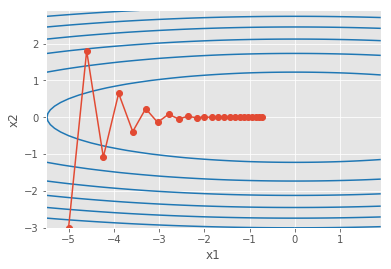

In [22]:
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

def train_2d(trainer):
    x1, x2 = -5, -3
    s1, s2 = 0, 0
    ret = [(x1, x2)]
    for i in range(23):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        ret.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i+1, x1, x2))
    return ret

def show_trace_2d(f, res):
    x1, x2 = zip(*res)
    plt.plot(x1, x2, '-o')
    x1 = np.arange(-5.5, 2.0, 0.1)
    x2 = np.arange(-3.0, 3.0, 0.1)
    x1, x2 = np.meshgrid(x1, x2)
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')
    
optimi = train_2d(gd_2d)
show_trace_2d(f_2d, optimi)

目标函数在竖直方向（ $x_2$ 轴）比在水平方向（ $x_1$ 轴）的斜率的绝对值更大，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。在水平方向，自变量趋于最优值；而竖直方向，自变量在最优值附近抖动。

更小的学习率可以避免在竖直方向的抖动，但在水平方向优化变慢。更大学习率会在竖直方向抖动更厉害，甚至overshoot.

epoch 23, x1 -4.774990, x2 -1.173166


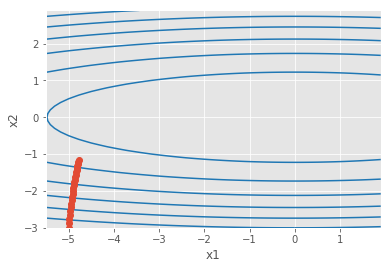

In [23]:
eta = 0.01
show_trace_2d(f_2d, train_2d(gd_2d))

epoch 23, x1 -0.155752, x2 2230431.408421


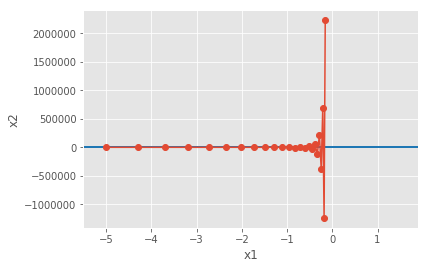

In [24]:
eta = 0.7
show_trace_2d(f_2d, train_2d(gd_2d))

解决思路：

1. 竖直方向和水平方向使用不同的学习率；

2. 竖直方向平滑时，当前优化方向包括了之前各次的优化的和，正负方向抵消，就不会抖动。

### 动量法（momentum）

加入系数$\gamma$，$\gamma$乘以历史梯度和，$1-\gamma$乘以当前梯度

epoch 23, x1 0.388988, x2 -0.238810


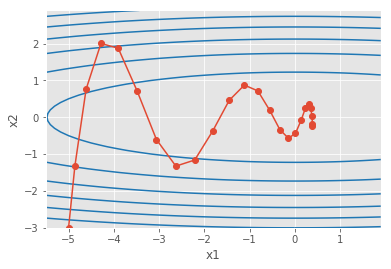

In [27]:
eta, gamma = 0.7, 0.8

def momentum_2d(x1, x2, h1, h2):
    h1 = gamma * h1 + (1 - gamma) * eta * 0.2 * x1
    h2 = gamma * h2 + (1 - gamma) * eta * 4 * x2
    return (x1 - h1, x2 - h2, h1, h2)

show_trace_2d(f_2d, train_2d(momentum_2d))

#### 指数加权移动平均（expontentially weighted moving average）

给定超参数$0 \leq \gamma < 1$，当前时间步$t$的变量$y_t$是上一时间步$t-1$的变量$y_{t-1}$和当前时间步另一变量$x_t$的线性组合：

$$y_t = \gamma y_{t-1} + (1-\gamma) x_t.$$

我们可以对$y_t$展开：

$$
\begin{aligned}
y_t  &= (1-\gamma) x_t + \gamma y_{t-1}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + \gamma^2y_{t-2}\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \gamma^3y_{t-3}\\
         &\ldots\\
         &= (1-\gamma)x_t + (1-\gamma) \cdot \gamma x_{t-1} + (1-\gamma) \cdot \gamma^2x_{t-2} + \ldots + (1-\gamma) \cdot \gamma^nx_{t-n} + \ldots\\
\end{aligned}
$$

令$\gamma = 0.95$，则$1 - \gamma = 0.05$，

$\frac{1}{1-\gamma} = 20$，

$\gamma^{20} = 0.3584859224085419 \approx 0.36787944117144233 = \frac{1}{e}$

如果把$\frac{1}{e}$当作一个比较小的数，我们近似的忽略所有含$\gamma^{1/(1-\gamma)}$和比$\gamma^{1/(1-\gamma)}$更高阶的系数的项。例如，当$\gamma=0.95$时，

$$y_t \approx 0.05 \sum_{i=0}^{19} 0.95^i x_{t-i}$$

在实际中，我们常常将$y_t$看作是对最近$1/(1-\gamma)$个时间步的$x_t$值的加权平均。


#### 总结

由指数加权移动平均的形式可得，
$$\boldsymbol{h}_t \leftarrow \gamma \boldsymbol{h}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{f}_t\right) $$

速度变量$\boldsymbol{h}_t$实际上对序列$\{\eta_{t-i}\boldsymbol{f}_{t-i} /(1-\gamma):i=0,\ldots,1/(1-\gamma)-1\}$做了指数加权移动平均。

相比于小批量随机梯度下降，动量法在每个时间步的自变量更新量，近似于将小批量随机梯度下降对应的最近$1/(1-\gamma)$个时间步的更新量做了指数加权移动平均后再除以$(1-\gamma)$。

在动量法中，自变量在各个方向上的移动幅度不仅取决当前梯度，还取决于过去的各个梯度在各个方向上是否一致。之前示例的优化问题中，所有梯度在水平方向上为正（向右），而在竖直方向上时正（向上）时负（向下）。这样，我们就可以使用较大的学习率，从而使自变量向最优解更快移动。

之前练习用到的的Adam就是在这个基础上做的优化算法。